In [35]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import helper1
import helper1_mate
import matplotlib.ticker as ticker
from matplotlib import cm

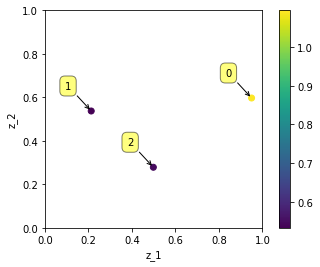

In [316]:
T = 3
alpha = 45
data = helper1.generate_data(T,alpha=alpha,sigma_reward=0.001)
helper1.plot_data(data, labels=True)

In [295]:
def insert_auxiliary_data(data, sigma_reward_model): 
  z_T = data['z']
  r = data['r']
  N = z_T.shape[0]

  #insert cov_inverses and mus
  z_T = tf.reshape(data['z'], (N, 1, 2)) #z rows
  z = tf.reshape(z_T, (N, 2, 1)) #z columns
  cov_inverses = 1/(sigma_reward_model**2)*tf.matmul(z, z_T)
  data['cov_inverses'] = cov_inverses
  

  covs = tf.linalg.inv(cov_inverses)
  mus = tf.multiply(tf.squeeze(tf.matmul(covs, z)), tf.expand_dims(r, -1))
  data['mus'] = mus
  

  # insert cov_primes and mu_primes
  cov_inverses_ = tf.concat([tf.expand_dims(tf.eye(2), 0), cov_inverses], 0) # concatenate the mu of the prior
  cov_primes = tf.convert_to_tensor([tf.linalg.inv(tf.reduce_sum(cov_inverses_[:i], axis = 0)) for i in range(1, N+2)])
  

  mus_ = tf.concat([tf.expand_dims(tf.constant([0., 0.]), 0), mus], 0) # concatenate the mu of the prior
  mus_ = tf.reshape(mus_, (N+1, 2, 1))
  aux = matmul(cov_inverses_, mus_)
  mu_primes = tf.squeeze(tf.convert_to_tensor([tf.matmul(cov_primes[i-1], tf.reduce_sum(aux[:i], axis = 0)) for i in range(1, N+2)]))
  
  data['c'] = tfd.MultivariateNormalFullCovariance(loc = mu_primes[:N], covariance_matrix = cov_primes[:N]).prob(mus)

  data['mus'] = tf.cast(data['mus'], 'float64')
  data['cov_inverses'] = tf.cast(data['cov_inverses'], 'float64')
  data['c'] = tf.cast(data['c'], 'float64')
  return data

In [206]:
sigma_reward_model = .4

In [317]:
data = insert_auxiliary_data(data, sigma_reward_model)

In [334]:
data['mus']

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[-0.04467099,  0.30949682],
       [ 0.05103382,  0.00421597],
       [-0.24653021,  1.42566359]])>

In [335]:
data['cov_inverses']

<tf.Tensor: shape=(3, 2, 2), dtype=float64, numpy=
array([[[5.642272  , 3.54727125],
        [3.54727125, 2.2301538 ]],

       [[0.28260407, 0.71448565],
        [0.71448565, 1.80637801]],

       [[1.55255818, 0.8686049 ],
        [0.8686049 , 0.48595569]]])>

In [336]:
data['c']

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.15156074, 0.46454841, 0.02455632])>

In [328]:
def compute_mmllh_analytically(data, sigma_reward_model):
  pi = np.pi
  ksi = 1/(sigma_reward_model*np.sqrt(2*pi))

  z_T = tf.cast(data['z'], 'float64')
  r = tf.cast(data['r'], 'float64')
  N = z_T.shape[0]
  mus = data['mus']
  cov_invs = data['cov_inverses']
  covs = tf.linalg.inv(cov_invs)
  print(covs)
  c = data['c']

  first_term = tf.math.pow(2*pi/ksi, N)

  z_T = tf.reshape(z_T, (N, 1, 2)) #z rows
  z = tf.reshape(z_T, (N, 2, 1)) #z columns
  second_term = tf.math.exp(-1/(2*sigma_reward_model**2)*tf.reduce_sum(tf.multiply(1 + tf.matmul(tf.matmul(z_T, covs), z), tf.math.pow(r, 2))))

  third_term = tf.reduce_prod(tf.math.sqrt(tf.linalg.det(covs)))

  fourth_term = tf.reduce_prod(c)


  print(first_term)
  print(second_term)
  print(third_term)
  print(fourth_term)
  return first_term*second_term*third_term*fourth_term

Ennyi jön ki:

In [329]:
compute_mmllh_analytically(data, sigma_reward_model)

tf.Tensor(
[[[ 2.24544107e+06 -3.57158711e+06]
  [-3.57158711e+06  5.68094868e+06]]

 [[ 4.92076700e+07 -1.94633536e+07]
  [-1.94633536e+07  7.69843725e+06]]

 [[ 7.34392976e+07 -1.31266565e+08]
  [-1.31266565e+08  2.34627942e+08]]], shape=(3, 2, 2), dtype=float64)
tf.Tensor(250.02842295494196, shape=(), dtype=float64)
tf.Tensor(3.754711808265941e-09, shape=(), dtype=float64)
tf.Tensor(64381550474.18325, shape=(), dtype=float64)
tf.Tensor(0.0017289439386410327, shape=(), dtype=float64)


<tf.Tensor: shape=(), dtype=float64, numpy=104.4980852719175>

Elvileg ennyinek kell kijönnie:

In [313]:
gamma_prior = tfd.Normal(loc=[0.0, 0.0], scale=[1.0, 1.0])
N_prior_samples = 5000

a = [gamma_prior.sample(N_prior_samples)]
mllhs = helper1_mate.compute_log_mllhs_by_gamma(data['z'],data['r'],a,sigma_reward_model,verbose=True)

3/3 [==============================] - 9s 3s/step


In [330]:
np.exp(mllhs[-1])

array([0.13963505])